    
    1. 프로젝트목적 : 
    2022 최고의 밈중 하나인 would like hater one for the chuck wonder like station 동네사람들..
    제주 방언에 대해 감명깊어서 제주방언을 표준어로 바꿔주고, 표준어를 제주도로 바꿔서 알려주는 챗봇이 있으면 
    어떨까 하고 시작하였습니다.

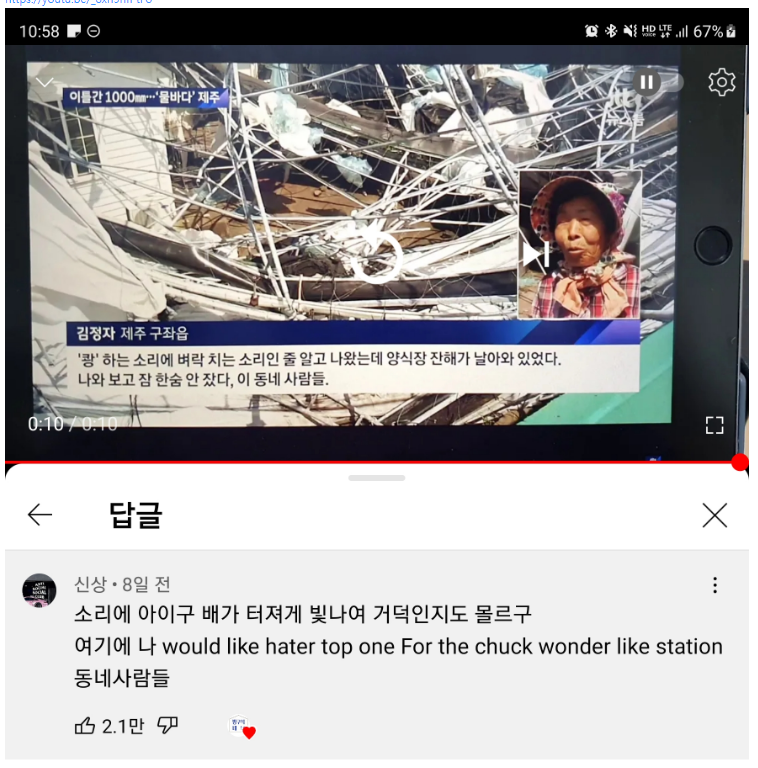


    ai 허브에서 필요한 데이터를 찾다가, 경상도, 충청도, 전라도, 강원도 데이터들을 또한 있음을 알게 되었고,
    제주 만을 사용하면 너무 단순하고 심플한 느낌이 들어 총 5개 지역에 대한 방언-표준어, 표준어-방언 찾기 챗봇으로 범위를 넓혔습니다.
    전라도, 충청도는 ai 허브 데이터셋 자체에서 decode가 되지 않아서 문의 했지만 기한 내에 답이 오지 않아
    강원도, 경상도, 제주도를 기반으로 한 방언-표준어 챗봇을 개발했습니다~!
    
    

    2. 기존에 개발되어 있는 제주 방언 번역기에서도 번역하지 못했던 몇 문장들을 번역해준답니다~!
    
    예 ) 다 제주도로오메 
    
 
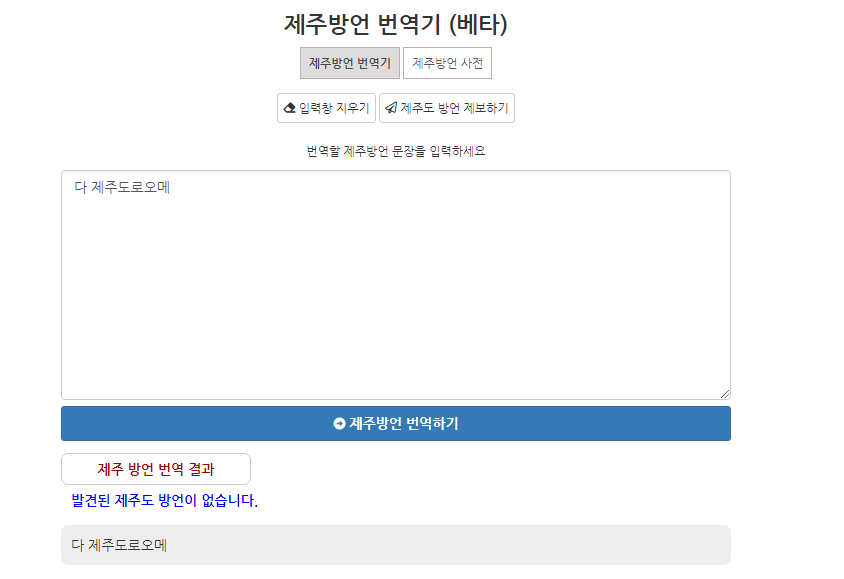

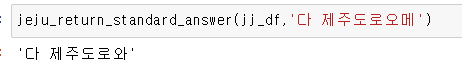

    제주 방언 번역기는 번역하지 못하지만 해당 챗봇은 실제 대화를 기반으로 해서, 실 문장 번역에 강합니다~! 
    단어는 뭐 네이버 방언 사전이 제일 강할 듯 ?(^,^)
    
    
    3. 개발 과정 요약
    
    3-(1) 데이터 전처리 (가장 시간이 많이 걸림)
    3-(2) sentence transformer를 사용하여 각 단어, 문장 들에 대하여 embedding
    3-(3) cosine 유사도를 기반으로 하여 embedding값을 비교하도록 각 도시별 함수 만들기
    3-(4) 함수를 합쳐 모듈화 하기

## 0. 필요한 라이브러리 import 

In [1]:
import os
import json
import numpy as np
import pandas as pd
import urllib.request
from numpy import dot
from numpy.linalg import norm
from sentence_transformers import SentenceTransformer

## 1. DataSet 구축하기

    (1) AI hub에서 한국어 방언 발화(제주도, 경상도, 전라도, 충청도 데이터)를 다운로드 받음
    (2) json/txt 파일로 구성되어 있었고, json 데이터만을 사용했고, 해당 데이터가 유니코드로 인코딩 되어 있어,
    디코딩 하여 데이터프레임으로 변경함
       

- 한국어 방언 발화(강원도)
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=118
- 한국어 방언 발화(경상도)
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=119
- 한국어 방언 발화(전라도)
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=120
- 한국어 방언 발화(제주도)
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=121
- 한국어 방언 발화(충청도)
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=122


       ** 위 데이터 중 전라도, 충청도는 데이터셋 자체 decode가 안되서 ai hub에 문의했지만 일주일 째 문의 처리중 ㅠㅠ
        사용할 수 있는 강원도, 경상도, 제주도 데이터셋만을 사용하기로 했습니다~! **




In [2]:
os.listdir('./data/')

['강원도', '경상도', '제주도']

In [4]:
jeju = os.listdir('./data/제주도')
gyung = os.listdir('./data/경상도')
gang = os.listdir('./data/강원도')

In [6]:
with open('./data/제주도/'+jeju[0],'r') as f:
    json_data = json.load(f)
    df = pd.DataFrame(json_data['utterance'])
df

,id,start,end,speaker_id,form,standard_form,dialect_form,note,eojeolList
0,DZES20000002.1.1.1,0.00,3.690000,2,난 진짜 벌초 할때 뱀나오잖아 뱀도,난 진짜 벌초 할때 뱀나오잖아 뱀도,난 진짜 벌초 할때 뱀나오잖아 뱀도,,"[{'id': 1, 'eojeol': '난', 'standard': '난', 'is..."
1,DZES20000002.1.1.2,3.69,4.520000,1,어어 그니까,어어 그니까,어어 그니까,,"[{'id': 1, 'eojeol': '어어', 'standard': '어어', '..."
2,DZES20000002.1.1.3,4.52,5.200000,2,아 잘도,아 잘도,아 잘도,,"[{'id': 1, 'eojeol': '아', 'standard': '아', 'is..."
3,DZES20000002.1.1.4,5.21,6.805455,1,예초기 뱀도 짤려,예초기 뱀도 짤려,예초기 뱀도 짤려,,"[{'id': 1, 'eojeol': '예초기', 'standard': '예초기',..."
4,DZES20000002.1.1.5,6.82,9.450000,2,어 그니까 완전 끔찍해,어 그니까 완전 끔찍해,어 그니까 완전 끔찍해,,"[{'id': 1, 'eojeol': '어', 'standard': '어', 'is..."
...,...,...,...,...,...,...,...,...,...
833,DZES20000002.1.1.834,1788.16,1789.350000,1,원수인가?,원수인가?,원수인가?,,"[{'id': 1, 'eojeol': '원수인가?', 'standard': '원수인..."
834,DZES20000002.1.1.835,1789.36,1790.870000,1,애물단지인가?,애물단지인가?,애물단지인가?,,"[{'id': 1, 'eojeol': '애물단지인가?', 'standard': '애..."
835,DZES20000002.1.1.836,1791.00,1795.860000,1,하여 결단했으니 앞으로 우리 집안의 명절은 없다,하여 결단했으니 앞으로 우리 집안의 명절은 없다,하여 결단했으니 앞으로 우리 집안의 명절은 없다,,"[{'id': 1, 'eojeol': '하여', 'standard': '하여', '..."
836,DZES20000002.1.1.837,1795.87,1797.800000,1,이러이러한 이러이러한 내용이야,이러이러한 이러이러한 내용이야,이러이러한 이러이러한 내용이야,,"[{'id': 1, 'eojeol': '이러이러한', 'standard': '이러이..."


In [8]:
from tqdm import tqdm

### `필요한 데이터 컬럼만 가져오기`

- 위 데이터에서 표준어(form), 표준어 문장(standard_form), 방언 문장(dialect_form) 만 가져옴

In [9]:
jeju_df = pd.DataFrame(columns=['dialect_form','form', 'standard_form'])

for data in tqdm(jeju):
    with open('./data/제주도/'+data,'r') as f:
        json_data = json.load(f)
        df = pd.DataFrame(json_data['utterance'])[['dialect_form','form', 'standard_form']]
        jeju_df = pd.concat([df, jeju_df])

100%|██████████████████████████████████████████████████████████████████████████████| 5042/5042 [09:48<00:00,  8.56it/s]


In [11]:
gyungsang_df = pd.DataFrame(columns=['dialect_form','form', 'standard_form'])

for data in tqdm(gyung):
    with open('./data/경상도/'+data,'r') as f:
        json_data = json.load(f)
        df = pd.DataFrame(json_data['utterance'])[['dialect_form','form', 'standard_form']]
        gyungsang_df = pd.concat([df, gyungsang_df])

100%|██████████████████████████████████████████████████████████████████████████████| 7699/7699 [11:25<00:00, 11.23it/s]


In [12]:
gwangwon_df = pd.DataFrame(columns=['dialect_form','form', 'standard_form'])

for data in tqdm(gang):
    with open('./data/강원도/'+data,'r') as f:
        json_data = json.load(f)
        df = pd.DataFrame(json_data['utterance'])[['dialect_form','form', 'standard_form']]
        gwangwon_df = pd.concat([df, gwangwon_df])

100%|██████████████████████████████████████████████████████████████████████████████| 5545/5545 [06:23<00:00, 14.45it/s]


In [13]:
jeju_df.to_csv('jeju_df.csv', index=False, encoding='utf-8-sig')
gyungsang_df.to_csv('gyungsang_df.csv', index=False, encoding='utf-8-sig')
gwangwon_df.to_csv('gwangwon_df.csv', index=False, encoding='utf-8-sig')

## 2. 불러온 Dataset 가공하기

    2-1. 각 도의 데이터셋에서 방언이 있는 부분만 추출하기 (get_data 함수)
    2-2. 중간에 한 문장에 방언이 2개 있는 경우가 있어서, 1개만 있는 경우만 가져옴( preprocessing_1 함수)
    2-3. 표준어 문장/방언문장 데이터셋과 표준어 단어/방언 단어 데이터셋을 city별로 만듦
    2-4. 2-3에서 만들어진 city별 단어와 문장 데이터셋 merge (get_standard_dialect_df 함수)
    2-5. 각 표준어에 따라 데이터셋 생성

In [2]:
os.listdir('./')

['.ipynb_checkpoints',
 'BerTopic.ipynb',
 'chatbot_final.csv',
 'chatbot_label.xlsx',
 'gwangwon_df.csv',
 'gyungsang_df.csv',
 'jeju.npy',
 'jeju_data.csv',
 'jeju_data.npy',
 'jeju_df.csv',
 'sentence_transformer.ipynb',
 'sentence_transformer_ver2.ipynb',
 'Untitled.ipynb']

In [3]:
jeju = pd.read_csv('./jeju_df.csv')
gwangwon = pd.read_csv('./gwangwon_df.csv')
gyungsang = pd.read_csv('./gyungsang_df.csv')

**`각 데이터 총 개수`**

In [4]:
print(jeju.shape)
print(gwangwon.shape)
print(gyungsang.shape)

(2774257, 3)
(1850036, 3)
(2088717, 3)


**`2-1. 각 도의 데이터셋에서 방언이 있는 부분만 추출하기`**

In [5]:
def get_data(temp):
    df = temp.copy()
    df = df.dropna()
    df['check'] = df['form'].apply(lambda x: x if '(' in x else '-')
    df = df.drop(df.loc[df['check']=='-'].index).reset_index(drop=True)
    df['lang'] = df['form'].apply(lambda x: ''.join(x.split('/')))
    df['lang'] = df['lang'].apply(lambda x: ''.join(x.split('(')[1:]))
    df['lang'] = df['lang'].apply(lambda x: '/'.join(x.split(')')[:-1]))

    df1 = df.loc[df['lang'].str.split('/').str.len()>2].drop(columns='check')

    df2 = df.loc[df['lang'].str.split('/').str.len()==2].drop(columns='check')
    df2 = df2.loc[df2['lang'].str.len()>1]  # 매칭되는 방언이 없는 경우 데이터 삭제
    
    df1 = df1.reset_index()
    df2 = df2.reset_index()
    return df1, df2

In [6]:
jeju_1, jeju_2 = get_data(jeju)
display(jeju_1.head(3))
display(jeju_2.head(3))

print(jeju_1.shape, jeju_2.shape)

gwangwon_1, gwangwon_2 = get_data(gwangwon)
display(gwangwon_1.head(3))
display(gwangwon_2.head(3))

print(jeju_1.shape, jeju_2.shape)

gyungsang_1, gyungsang_2 = get_data(gyungsang)
display(gyungsang_1.head(3))
display(gyungsang_2.head(3))

print(gyungsang_1.shape, gyungsang_2.shape)

,index,dialect_form,form,standard_form,lang
0,0,이렇게 교수님들이랑 있는 느낌이라(부난)/(서)(이)/(#이),이렇게 교수님들이랑 있는 느낌이라(부난)/(서)(이)/(#이),이렇게 교수님들이랑 있는 느낌이라(부난)/(서)(이)/(#이),부난/서/이/#이
1,2,겅행 별 말 안 하맨.,(겅)/(그렇게)(행)/(해서) 별 말 안 (하맨.)/(해.),그렇게해서 별 말 안 해.,겅/그렇게/행/해서/ 별 말 안 하맨./해.
2,6,시작하기 전이랑(이)/(#이) 끝나고 나서랑(이)/(#이),시작하기 전이랑(이)/(#이) 끝나고 나서랑(이)/(#이),시작하기 전이랑(이)/(#이) 끝나고 나서랑(이)/(#이),이/#이/ 끝나고 나서랑이/#이


,index,dialect_form,form,standard_form,lang
0,1,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러)/(#부러),멀게 느껴져(부러)/(#부러),부러/#부러
1,3,굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),이/#이
2,4,대화하는 시간 자체가 있는 거?,대화하는 시간 자체가 있는 (거?)/(거야?),대화하는 시간 자체가 있는 거야?,거?/거야?


(546750, 5) (682115, 5)


,index,dialect_form,form,standard_form,lang
0,11,저도 아버지 매로 닮아가고 있다와.,저도 아버지 (매로)/(처럼) 닮아가고 (있다와.)/(있습니다.),저도 아버지 처럼 닮아가고 있습니다.,매로/처럼/ 닮아가고 있다와./있습니다.
1,17,저도 당신 매로 멋지게 살고 싶다와.,저도 당신 (매로)/(처럼) 멋지게 살고 (싶다와.)/(싶습니다.),저도 당신 처럼 멋지게 살고 싶습니다.,매로/처럼/ 멋지게 살고 싶다와./싶습니다.
2,26,집 안에 매무가 붙어있다와.,집 안에 (매무)/(매미)가 (붙어있다와.)/(있습니다.),집 안에 매미가 있습니다.,매무/매미/가 붙어있다와./있습니다.


,index,dialect_form,form,standard_form,lang
0,0,어릴 때 어떤 날은 하루종일 매무를 잡았었어.,어릴 때 어떤 날은 하루종일 (매무)/(매미)를 잡았었어.,어릴 때 어떤 날은 하루종일 매미를 잡았었어.,매무/매미
1,1,쉬는 날인데도 이른 아침부터 매무가 우는구나.,쉬는 날인데도 이른 아침부터 (매무)/(매미)가 우는구나.,쉬는 날인데도 이른 아침부터 매미가 우는구나.,매무/매미
2,2,창문에 매무가 붙어있으니 떼라.,창문에 (매무)/(매미)가 붙어있으니 떼라.,창문에 매미가 붙어있으니 떼라.,매무/매미


(546750, 5) (682115, 5)


,index,dialect_form,form,standard_form,lang
0,4,어~ 저렇게 이케 방송 프로그램을 챙겨 가주구 보고 또 거기에 또 유튜브도 보고,어~ 저렇게 (이케)/(이렇게) 방송 프로그램을 챙겨 (가주구)/(가지고) 보고 또...,어~ 저렇게 이렇게 방송 프로그램을 챙겨 가지고 보고 또 거기에 또 유튜브도 보고,이케/이렇게/ 방송 프로그램을 챙겨 가주구/가지고
1,5,그~ 또 카페 같은 데 가입해 가주구 막 이케 하는 게 난 너무 신기했구,그~ 또 카페 같은 데 가입해 (가주구)/(가지고) 막 (이케)/(이렇게) 하는 게...,그~ 또 카페 같은 데 가입해 가지고 막 이렇게 하는 게 난 너무 신기했구,가주구/가지고/ 막 이케/이렇게
2,8,나는 잘 모르겠던데 엄마는 왜 그~ 트로트 그 프로그램에 빠져서 임영웅을 많이 이케...,나는 잘 모르겠던데 엄마는 왜 그~ 트로트 그 프로그램에 빠져서 임영웅을 많이 (이...,나는 잘 모르겠던데 엄마는 왜 그~ 트로트 그 프로그램에 빠져서 임영웅을 많이 이렇...,이케/이렇게/ 좋아하게 됐는지 그게 쫌/조금


,index,dialect_form,form,standard_form,lang
0,0,요즘에 트로트가 진짜 많이 이케 대세잖아요.,요즘에 트로트가 진짜 많이 (이케)/(이렇게) 대세잖아요.,요즘에 트로트가 진짜 많이 이렇게 대세잖아요.,이케/이렇게
1,1,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가주구 막 챙겨 보고 막 이러는 걸 한...,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 (가주구)/(가지고) 막 챙겨 보고 막...,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가지고 막 챙겨 보고 막 이러는 걸 한...,가주구/가지고
2,2,이번에 막 미스트 트롯 그거 하고 거기에 완전 빠져 가주구,이번에 막 미스트 트롯 그거 하고 거기에 완전 빠져 (가주구)/(가지고),이번에 막 미스트 트롯 그거 하고 거기에 완전 빠져 가지고,가주구/가지고


(80123, 5) (260334, 5)


**`2-2. 중간에 한 문장에 방언이 2개 있는 경우가 있어서, 1개만 있는 경우만 가져옴`**

In [7]:
def preprocessing_1(temp):
    df = temp.copy()
    
    # answer에 해당하는 부분 지우기 
    df['dialect_form'] = df['dialect_form'].apply(lambda x: x.split(')')[0] if len(x.split(')'))>2 else x)
    df['dialect_form'] = df['dialect_form'].apply(lambda x: x.split('(')[0] if len(x.split('('))>2 else x)
    
    #방언/표준어 전처리
    df['lang'] = df['lang'].apply(lambda x: x.replace('.', '') if '.' in x else x)
    #방언/표준어 매칭이 아닌 데이터 지우기
    df['lang'] = df['lang'].apply(lambda x: x if len(x.split('/')[1])>1 else '-')
    df = df.loc[df['lang']!='-'].reset_index(drop=True)
    
    # 표준어 문장 - 방언 문장 데이터셋
    sentence_df = df[['index','standard_form', 'dialect_form']]

    # 표준어 단어 - 방언 단어 데이터셋
    word_df = df[['index','lang']]
    word_df['dialect'] = word_df['lang'].apply(lambda x: x.split('/')[0])
    word_df['standard'] = word_df['lang'].apply(lambda x: x.split('/')[1])
    word_df = word_df.drop(columns=['lang'])
    word_df = word_df.drop_duplicates()
    word_df = word_df[['index','standard','dialect']]
    
    return sentence_df, word_df

**`2-3. 표준어 문장/방언문장 데이터셋과 표준어 단어/방언 단어 데이터셋을 city별로 만듦`**

In [8]:
city = 'jeju'
jeju_sentence, jeju_word = preprocessing_1(jeju_2)
jeju_sentence.columns = [col+'_'+city if col == 'dialect_form' else col for col in jeju_sentence.columns]
jeju_word.columns = [col+'_'+city if col == 'dialect' else col for col in jeju_word.columns]  

display(jeju_sentence.head(5))
display(jeju_word.head(5))

C:\Users\PC\AppData\Local\Temp\ipykernel_17180\4200830943.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['dialect'] = word_df['lang'].apply(lambda x: x.split('/')[0])
C:\Users\PC\AppData\Local\Temp\ipykernel_17180\4200830943.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['standard'] = word_df['lang'].apply(lambda x: x.split('/')[1])


,index,standard_form,dialect_form_jeju
0,1,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러
1,3,굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이
2,4,대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?
3,5,그니까 어,게난 어
4,8,선생님이 시간을 주거든 근데 별 얘기 안 하고 맨 처음 시간에도 막 자기소개 같은 ...,선생님이 시간을 주거든 근데 별 얘기 안 하고 맨 처음 시간에도 막 자기소개 같은 ...


,index,standard,dialect_jeju
0,1,#부러,부러
1,3,#이,이
2,4,거야?,거?
3,5,그니까,게난
4,8,하는데,하는디


In [9]:
city = 'gwangwon'

gwangwon_sentence, gwangwon_word = preprocessing_1(gwangwon_2)
gwangwon_sentence.columns = [col+'_'+city if col == 'dialect_form' else col for col in gwangwon_sentence.columns]
gwangwon_word.columns = [col+'_'+city if col == 'dialect' else col for col in gwangwon_word.columns]

display(gwangwon_sentence.head(5))
display(gwangwon_word.head(5))

C:\Users\PC\AppData\Local\Temp\ipykernel_17180\4200830943.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['dialect'] = word_df['lang'].apply(lambda x: x.split('/')[0])
C:\Users\PC\AppData\Local\Temp\ipykernel_17180\4200830943.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['standard'] = word_df['lang'].apply(lambda x: x.split('/')[1])


,index,standard_form,dialect_form_gwangwon
0,0,어릴 때 어떤 날은 하루종일 매미를 잡았었어.,어릴 때 어떤 날은 하루종일 매무를 잡았었어.
1,1,쉬는 날인데도 이른 아침부터 매미가 우는구나.,쉬는 날인데도 이른 아침부터 매무가 우는구나.
2,2,창문에 매미가 붙어있으니 떼라.,창문에 매무가 붙어있으니 떼라.
3,3,여름이라 그런지 매미의 소리가 쉬지 않는구나.,여름이라 그런지 매무의 소리가 쉬지 않는구나.
4,4,이제 매미 소리는 제발 그만 듣고 싶소.,이제 매무 소리는 제발 그만 듣고 싶소.


,index,standard,dialect_gwangwon
0,0,매미,매무
1,1,매미,매무
2,2,매미,매무
3,3,매미,매무
4,4,매미,매무


In [10]:
city = 'gyungsang'
gyungsang_sentence, gyungsang_word = preprocessing_1(gyungsang_2)

gyungsang_sentence.columns = [col+'_'+city if col == 'dialect_form' else col for col in gyungsang_sentence.columns]
gyungsang_word.columns = [col+'_'+city if col == 'dialect' else col for col in gyungsang_word.columns]

display(gyungsang_sentence.head(5))
display(gyungsang_word.head(5))

C:\Users\PC\AppData\Local\Temp\ipykernel_17180\4200830943.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['dialect'] = word_df['lang'].apply(lambda x: x.split('/')[0])
C:\Users\PC\AppData\Local\Temp\ipykernel_17180\4200830943.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['standard'] = word_df['lang'].apply(lambda x: x.split('/')[1])


,index,standard_form,dialect_form_gyungsang
0,0,요즘에 트로트가 진짜 많이 이렇게 대세잖아요.,요즘에 트로트가 진짜 많이 이케 대세잖아요.
1,1,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가지고 막 챙겨 보고 막 이러는 걸 한...,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가주구 막 챙겨 보고 막 이러는 걸 한...
2,2,이번에 막 미스트 트롯 그거 하고 거기에 완전 빠져 가지고,이번에 막 미스트 트롯 그거 하고 거기에 완전 빠져 가주구
3,3,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 조금 ...,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 쪼꼼 ...
4,6,묘미를 저~ 조금 모르겠더라구요.,묘미를 저~ 쫌 모르겠더라구요.


,index,standard,dialect_gyungsang
0,0,이렇게,이케
1,1,가지고,가주구
2,2,가지고,가주구
3,3,조금,쪼꼼
4,6,조금,쫌


In [13]:
from tqdm import tqdm

**`2-4. 2-3에서 만들어진 city별 단어와 문장 데이터셋 merge`**

In [14]:
def get_standard_dialect_df(df,city):
    dialect_city = 'dialect_'+city
    temp_df = df[['index','standard']].drop_duplicates(subset=['standard']).reset_index(drop=True)
    temp_df[dialect_city] = None
    
    for i in tqdm(range(temp_df.shape[0])):
        standard = temp_df.loc[i, 'standard']
        dialect = list(df.loc[df['standard']==standard][dialect_city].tolist())
        temp_df.at[i, dialect_city] = [dialect]
    
    return temp_df

In [15]:
standard_to_jeju_w = get_standard_dialect_df(jeju_word, 'jeju')
standard_to_jeju_w

100%|██████████████████████████████████████████████████████████████████████████| 105200/105200 [48:05<00:00, 36.45it/s]


,index,standard,dialect_jeju
0,1,#부러,"[[부러, 부러, 부러]]"
1,3,#이,"[[이, 이, 이, 이, 이, 이, 이, 이, 이, 이, 이, 이, 이, 이, 이,..."
2,4,거야?,"[[거?, 거?, 거라?, 거?, 거?, 거?, 거?, 거?, 거?, 거?, 거?,..."
3,5,그니까,"[[게난, 게난, 게난, 게난, 게난, 게난, 게난, 게난, 그니까이, 게난, 게난..."
4,8,하는데,"[[하는디, 하는디, 하는디, 하는디, 해신디, 허는데, 하는디, 하는디, 하는디,..."
...,...,...,...
105195,1292383,종지,"[[종재기, 종재기]]"
105196,1292436,맑아져서,[[맑아져그네]]
105197,1292445,밖깥에서,[[배기테서]]
105198,1292491,제주도로와,[[제주도로오메]]


In [16]:
standard_to_gwangwon_w = get_standard_dialect_df(gwangwon_word, 'gwangwon')
standard_to_gwangwon_w

100%|████████████████████████████████████████████████████████████████████████████| 50925/50925 [26:16<00:00, 32.29it/s]


,index,standard,dialect_gwangwon
0,0,매미,"[[매무, 매무, 매무, 매무, 매무, 매무, 매무, 매무, 매무, 매무, 매무, ..."
1,7,매섭네요,"[[매숩네요, 매숩네요, 매숩네요, 매숩네요, 매숩네요, 매숩네요, 매숩네요, 매숩..."
2,9,처럼,"[[매야로, 매야로, 매로, 매로, 매로, 매로, 매로, 매로, 매야로, 매야로, ..."
3,31,미련,"[[매련, 매련, 매련, 매련, 매련, 매련, 매련, 매련, 매련, 매련, 매련, ..."
4,36,미련하여,"[[매련시루와, 매련시루와, 매련시루와, 매련시루와, 매련시루와, 매련시루와, 매련..."
...,...,...,...
50920,996500,절이기도,[[절구기도]]
50921,996513,죽겠는거야,[[죽겠는거여]]
50922,996514,촌년이라도,[[촌년이래도]]
50923,996518,나더라?,[[나드라?]]


In [17]:
standard_to_gyungsang_w = get_standard_dialect_df(gyungsang_word, 'gyungsang')
standard_to_gyungsang_w

100%|████████████████████████████████████████████████████████████████████████████| 17437/17437 [03:02<00:00, 95.47it/s]


,index,standard,dialect_gyungsang
0,0,이렇게,"[[이케, 이르케, 이래, 이래, 이래, 이르케, 이래, 이래, 이래, 이래, 이르..."
1,1,가지고,"[[가주구, 가주구, 가주고, 가주고, 가주고, 가주고, 가꼬, 가주고, 가주구, ..."
2,3,조금,"[[쪼꼼, 쫌, 쫌, 쫌, 쫌, 쫌, 쫌, 쪼꼼, 쪼꼼, 쫌, 쫌, 쫌, 쫌, 쫌,..."
3,9,얘가,"[[야가, 야가, 야가, 야가, 야가, 야가, 야가, 야가, 야가, 야가, 야가, ..."
4,11,나와서,"[[나와가, 나와가, 나와가, 나와가, 나와가, 나와가, 나와가, 나와가, 나와가,..."
...,...,...,...
17432,369944,꺼냈어,[[꺼내데]]
17433,369952,좋은건가,[[좋은긴가]]
17434,369956,꺼내먹으면,[[꺼내무면]]
17435,369965,남이 하는거,[[넘하는거]]


In [18]:
standard_to_jeju_w['dialect_jeju'] = standard_to_jeju_w['dialect_jeju'].apply(lambda x: ','.join(list(set(x[0]))))
standard_to_gwangwon_w['dialect_gwangwon'] = standard_to_gwangwon_w['dialect_gwangwon'].apply(lambda x: ','.join(list(set(x[0]))))
standard_to_gyungsang_w['dialect_gyungsang'] = standard_to_gyungsang_w['dialect_gyungsang'].apply(lambda x: ','.join(list(set(x[0]))))

In [19]:
display(standard_to_jeju_w.head(3))
display(standard_to_gwangwon_w.head(3))
display(standard_to_gyungsang_w.head(3))

,index,standard,dialect_jeju
0,1,#부러,부러
1,3,#이,"리,이?,애,거,아,잉,어,이예, 이 ,인, 이,이 ,겡,예,이"
2,4,거야?,"거라,거내?,건가?,거마씸?,거멘?,거꽈?,거수까?,하는거,거임?,라는거임?,거,껀..."


,index,standard,dialect_gwangwon
0,0,매미,매무
1,7,매섭네요,매숩네요
2,9,처럼,"맹케로,메로,매로,아버지매양,쓰레기맨치로,쓰레기터맨치로,매양,매야로,모양,맨치로,매..."


,index,standard,dialect_gyungsang
0,0,이렇게,"캐,어케,이케,이러케,이러게,요러케,그케,여케,케,이캐,그까,인자,이라카,이래,그래..."
1,1,가지고,"가주구,가주고,가지구,갖꼬,가잡고,가주,가져고,그래 가주구,가,갖고,가꼬,가이고"
2,3,조금,"쬐금,짜끔,짐,쪼껌,쪼깨,쪼꼼,쬐까,조끔,쪼끔,쪼맨찬,쫌,쬐끔,쪼금?,쪼께,째매,째..."


In [20]:
standard_to_jeju_s = pd.merge(standard_to_jeju_w, jeju_sentence, on='index')
standard_to_gwangwon_s = pd.merge(standard_to_gwangwon_w, gwangwon_sentence, on='index')
standard_to_gyungsang_s = pd.merge(standard_to_gyungsang_w, gyungsang_sentence, on='index')
display(standard_to_jeju_s.head(3))
display(standard_to_gwangwon_s.head(3))
display(standard_to_gyungsang_s.head(3))

,index,standard,dialect_jeju,standard_form,dialect_form_jeju
0,1,#부러,부러,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러
1,3,#이,"리,이?,애,거,아,잉,어,이예, 이 ,인, 이,이 ,겡,예,이",굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이
2,4,거야?,"거라,거내?,건가?,거마씸?,거멘?,거꽈?,거수까?,하는거,거임?,라는거임?,거,껀...",대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?


,index,standard,dialect_gwangwon,standard_form,dialect_form_gwangwon
0,0,매미,매무,어릴 때 어떤 날은 하루종일 매미를 잡았었어.,어릴 때 어떤 날은 하루종일 매무를 잡았었어.
1,7,매섭네요,매숩네요,비바람이 매섭네요.,비바람이 매숩네요.
2,9,처럼,"맹케로,메로,매로,아버지매양,쓰레기맨치로,쓰레기터맨치로,매양,매야로,모양,맨치로,매...",너 처럼 걱정 없고 싶어.,너 매야로 걱정 없고 싶어.


,index,standard,dialect_gyungsang,standard_form,dialect_form_gyungsang
0,0,이렇게,"캐,어케,이케,이러케,이러게,요러케,그케,여케,케,이캐,그까,인자,이라카,이래,그래...",요즘에 트로트가 진짜 많이 이렇게 대세잖아요.,요즘에 트로트가 진짜 많이 이케 대세잖아요.
1,1,가지고,"가주구,가주고,가지구,갖꼬,가잡고,가주,가져고,그래 가주구,가,갖고,가꼬,가이고",나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가지고 막 챙겨 보고 막 이러는 걸 한...,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가주구 막 챙겨 보고 막 이러는 걸 한...
2,3,조금,"쬐금,짜끔,짐,쪼껌,쪼깨,쪼꼼,쬐까,조끔,쪼끔,쪼맨찬,쫌,쬐끔,쪼금?,쪼께,째매,째...",재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 조금 ...,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 쪼꼼 ...


In [21]:
standard_to_jeju_s = standard_to_jeju_s.rename(columns = {'index' : 'jeju_index'})
standard_to_gwangwon_s = standard_to_gwangwon_s.rename(columns = {'index' : 'gwangwon_index'})
standard_to_gyungsang_s = standard_to_gyungsang_s.rename(columns = {'index' : 'gyungsang_index'})

display(standard_to_jeju_s.head(3))
display(standard_to_gwangwon_s.head(3))
display(standard_to_gyungsang_s.head(3))

,jeju_index,standard,dialect_jeju,standard_form,dialect_form_jeju
0,1,#부러,부러,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러
1,3,#이,"리,이?,애,거,아,잉,어,이예, 이 ,인, 이,이 ,겡,예,이",굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이
2,4,거야?,"거라,거내?,건가?,거마씸?,거멘?,거꽈?,거수까?,하는거,거임?,라는거임?,거,껀...",대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?


,gwangwon_index,standard,dialect_gwangwon,standard_form,dialect_form_gwangwon
0,0,매미,매무,어릴 때 어떤 날은 하루종일 매미를 잡았었어.,어릴 때 어떤 날은 하루종일 매무를 잡았었어.
1,7,매섭네요,매숩네요,비바람이 매섭네요.,비바람이 매숩네요.
2,9,처럼,"맹케로,메로,매로,아버지매양,쓰레기맨치로,쓰레기터맨치로,매양,매야로,모양,맨치로,매...",너 처럼 걱정 없고 싶어.,너 매야로 걱정 없고 싶어.


,gyungsang_index,standard,dialect_gyungsang,standard_form,dialect_form_gyungsang
0,0,이렇게,"캐,어케,이케,이러케,이러게,요러케,그케,여케,케,이캐,그까,인자,이라카,이래,그래...",요즘에 트로트가 진짜 많이 이렇게 대세잖아요.,요즘에 트로트가 진짜 많이 이케 대세잖아요.
1,1,가지고,"가주구,가주고,가지구,갖꼬,가잡고,가주,가져고,그래 가주구,가,갖고,가꼬,가이고",나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가지고 막 챙겨 보고 막 이러는 걸 한...,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가주구 막 챙겨 보고 막 이러는 걸 한...
2,3,조금,"쬐금,짜끔,짐,쪼껌,쪼깨,쪼꼼,쬐까,조끔,쪼끔,쪼맨찬,쫌,쬐끔,쪼금?,쪼께,째매,째...",재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 조금 ...,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 쪼꼼 ...


In [22]:
s_temp = pd.merge(standard_to_jeju_s, standard_to_gwangwon_s, on='standard', how='left')
s_temp

,jeju_index,standard,dialect_jeju,standard_form_x,dialect_form_jeju,gwangwon_index,dialect_gwangwon,standard_form_y,dialect_form_gwangwon
0,1,#부러,부러,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러,NaN,NaN,NaN,NaN
1,3,#이,"리,이?,애,거,아,잉,어,이예, 이 ,인, 이,이 ,겡,예,이",굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이,NaN,NaN,NaN,NaN
2,4,거야?,"거라,거내?,건가?,거마씸?,거멘?,거꽈?,거수까?,하는거,거임?,라는거임?,거,껀...",대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?,505109.0,"거내?,끼야?,그나?,끼나?,거나,거임?,것이여?,거?,기라?, 그야?,겨?,거나?...",뭐하는 거야?,뭐하는 거나?
3,5,그니까,"허난,개넌,게난,그난예,게매,겨난예,핸까,거난 ,그난이,그니,그까,게매이,갱,거난이...",그니까 어,게난 어,549064.0,"긍까,그이까,그르이까,그까,근까,그니깐",그니까,그이까
4,8,하는데,"헌데,하는디야,한디이,하*는데,될건디,하는디이,하는게만은,해부는디,해는데이,하주마시...",선생님이 시간을 주거든 근데 별 얘기 안 하고 맨 처음 시간에도 막 자기소개 같은 ...,선생님이 시간을 주거든 근데 별 얘기 안 하고 맨 처음 시간에도 막 자기소개 같은 ...,512331.0,"해는데,되는데,한데,쓰겄는디,하는디,카는데",내가 있어서 밥두 챙겨주구 해야 하는데,내가 있어서 밥두 챙겨주구 해야 하는디
...,...,...,...,...,...,...,...,...,...
105195,1292383,종지,종재기,탁(종재기)/(종지)로,탁(종재기,421113.0,종제기,큰상에는 초간장 두 종지를 놓았다.,큰상에는 초간장 두 종제기를 놓았다.
105196,1292436,맑아져서,맑아져그네,요 중간에는 지금의 코로나땜에 좀 공기가 맑아져서,요 중간에는 지금의 코로나땜에 좀 공기가 맑아져그네,NaN,NaN,NaN,NaN
105197,1292445,밖깥에서,배기테서,밖깥에서 놀아 어어,배기테서 놀아 어어,NaN,NaN,NaN,NaN
105198,1292491,제주도로와,제주도로오메,다 제주도로와,다 제주도로오메,NaN,NaN,NaN,NaN


In [23]:
total_standard_dialect = pd.merge(s_temp, standard_to_gyungsang_s, on ='standard', how='left')
total_standard_dialect

,jeju_index,standard,dialect_jeju,standard_form_x,dialect_form_jeju,gwangwon_index,dialect_gwangwon,standard_form_y,dialect_form_gwangwon,gyungsang_index,dialect_gyungsang,standard_form,dialect_form_gyungsang
0,1,#부러,부러,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,#이,"리,이?,애,거,아,잉,어,이예, 이 ,인, 이,이 ,겡,예,이",굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,거야?,"거라,거내?,건가?,거마씸?,거멘?,거꽈?,거수까?,하는거,거임?,라는거임?,거,껀...",대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?,505109.0,"거내?,끼야?,그나?,끼나?,거나,거임?,것이여?,거?,기라?, 그야?,겨?,거나?...",뭐하는 거야?,뭐하는 거나?,2828.0,"거제?,거나?,거가?,꺼야?,거여?,기고?,거니?,꺼가?,거고?,겨?,끼가?,기가?,고?",최근에 다이어트 하고 있나 아니면은 잠깐 보류중인 거야?,최근에 다이어트 하고 있나 아니면은 잠깐 보류중인 거가?
3,5,그니까,"허난,개넌,게난,그난예,게매,겨난예,핸까,거난 ,그난이,그니,그까,게매이,갱,거난이...",그니까 어,게난 어,549064.0,"긍까,그이까,그르이까,그까,근까,그니깐",그니까,그이까,82193.0,"그니까,그까,근까,긍까",엠번방 같은 그니까 그~,엠번방 같은 그까 그~
4,8,하는데,"헌데,하는디야,한디이,하*는데,될건디,하는디이,하는게만은,해부는디,해는데이,하주마시...",선생님이 시간을 주거든 근데 별 얘기 안 하고 맨 처음 시간에도 막 자기소개 같은 ...,선생님이 시간을 주거든 근데 별 얘기 안 하고 맨 처음 시간에도 막 자기소개 같은 ...,512331.0,"해는데,되는데,한데,쓰겄는디,하는디,카는데",내가 있어서 밥두 챙겨주구 해야 하는데,내가 있어서 밥두 챙겨주구 해야 하는디,1417.0,"카는게,샀는데,해쌓는데,한데,칸데,허는데,카는데",대중화가 되면은 여러 가지 이렇게 개선이 되고 나면은 그때는 당연히 인제 우리가 거...,대중화가 되면은 여러 가지 이렇게 개선이 되고 나면은 그때는 당연히 인제 우리가 거...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105195,1292383,종지,종재기,탁(종재기)/(종지)로,탁(종재기,421113.0,종제기,큰상에는 초간장 두 종지를 놓았다.,큰상에는 초간장 두 종제기를 놓았다.,NaN,NaN,NaN,NaN
105196,1292436,맑아져서,맑아져그네,요 중간에는 지금의 코로나땜에 좀 공기가 맑아져서,요 중간에는 지금의 코로나땜에 좀 공기가 맑아져그네,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105197,1292445,밖깥에서,배기테서,밖깥에서 놀아 어어,배기테서 놀아 어어,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105198,1292491,제주도로와,제주도로오메,다 제주도로와,다 제주도로오메,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# 없는 방언들(결측값) 채워줌 
total_standard_dialect = total_standard_dialect.fillna('X')
total_standard_dialect.isnull().sum()

jeju_index                0
standard                  0
dialect_jeju              0
standard_form_x           0
dialect_form_jeju         0
gwangwon_index            0
dialect_gwangwon          0
standard_form_y           0
dialect_form_gwangwon     0
gyungsang_index           0
dialect_gyungsang         0
standard_form             0
dialect_form_gyungsang    0
dtype: int64

In [25]:
total_standard_dialect.head(3)

,jeju_index,standard,dialect_jeju,standard_form_x,dialect_form_jeju,gwangwon_index,dialect_gwangwon,standard_form_y,dialect_form_gwangwon,gyungsang_index,dialect_gyungsang,standard_form,dialect_form_gyungsang
0,1,#부러,부러,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러,X,X,X,X,X,X,X,X
1,3,#이,"리,이?,애,거,아,잉,어,이예, 이 ,인, 이,이 ,겡,예,이",굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이,X,X,X,X,X,X,X,X
2,4,거야?,"거라,거내?,건가?,거마씸?,거멘?,거꽈?,거수까?,하는거,거임?,라는거임?,거,껀...",대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?,505109.0,"거내?,끼야?,그나?,끼나?,거나,거임?,것이여?,거?,기라?, 그야?,겨?,거나?...",뭐하는 거야?,뭐하는 거나?,2828.0,"거제?,거나?,거가?,꺼야?,거여?,기고?,거니?,꺼가?,거고?,겨?,끼가?,기가?,고?",최근에 다이어트 하고 있나 아니면은 잠깐 보류중인 거야?,최근에 다이어트 하고 있나 아니면은 잠깐 보류중인 거가?


In [26]:
# 구축한 데이터셋에서 필요한 데이터들만 추출, 컬럼명 변경

total_standard_dialect = total_standard_dialect.drop(columns=['jeju_index','gwangwon_index', 'gyungsang_index'])
display(total_standard_dialect.head(3))

,standard,dialect_jeju,standard_form_x,dialect_form_jeju,dialect_gwangwon,standard_form_y,dialect_form_gwangwon,dialect_gyungsang,standard_form,dialect_form_gyungsang
0,#부러,부러,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러,X,X,X,X,X,X
1,#이,"리,이?,애,거,아,잉,어,이예, 이 ,인, 이,이 ,겡,예,이",굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이,X,X,X,X,X,X
2,거야?,"거라,거내?,건가?,거마씸?,거멘?,거꽈?,거수까?,하는거,거임?,라는거임?,거,껀...",대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?,"거내?,끼야?,그나?,끼나?,거나,거임?,것이여?,거?,기라?, 그야?,겨?,거나?...",뭐하는 거야?,뭐하는 거나?,"거제?,거나?,거가?,꺼야?,거여?,기고?,거니?,꺼가?,거고?,겨?,끼가?,기가?,고?",최근에 다이어트 하고 있나 아니면은 잠깐 보류중인 거야?,최근에 다이어트 하고 있나 아니면은 잠깐 보류중인 거가?


In [27]:
# 데이터셋 컬럼 재 설정

total_standard_dialect = total_standard_dialect.rename(columns = {'standard_form_x' : 'standard_from_jeju', 
                                                                  'standard_form_y' : 'standard_from_gwangwon',
                                                                 'standard_form' : 'standard_from_gyungsang'})
display(total_standard_dialect.head(3))

,standard,dialect_jeju,standard_from_jeju,dialect_form_jeju,dialect_gwangwon,standard_from_gwangwon,dialect_form_gwangwon,dialect_gyungsang,standard_from_gyungsang,dialect_form_gyungsang
0,#부러,부러,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러,X,X,X,X,X,X
1,#이,"리,이?,애,거,아,잉,어,이예, 이 ,인, 이,이 ,겡,예,이",굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이,X,X,X,X,X,X
2,거야?,"거라,거내?,건가?,거마씸?,거멘?,거꽈?,거수까?,하는거,거임?,라는거임?,거,껀...",대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?,"거내?,끼야?,그나?,끼나?,거나,거임?,것이여?,거?,기라?, 그야?,겨?,거나?...",뭐하는 거야?,뭐하는 거나?,"거제?,거나?,거가?,꺼야?,거여?,기고?,거니?,꺼가?,거고?,겨?,끼가?,기가?,고?",최근에 다이어트 하고 있나 아니면은 잠깐 보류중인 거야?,최근에 다이어트 하고 있나 아니면은 잠깐 보류중인 거가?


In [28]:
display(jeju_sentence.head(3))
display(jeju_word.head(3))

,index,standard_form,dialect_form_jeju
0,1,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러
1,3,굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이
2,4,대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?


,index,standard,dialect_jeju
0,1,#부러,부러
1,3,#이,이
2,4,거야?,거?


**`2-5. 각 표준어에 따라 데이터셋 생성`**

In [29]:
jj_w = jeju_word.drop_duplicates(subset=['standard','dialect_jeju'])
jj_df = pd.merge(jj_w, jeju_sentence, on='index').drop(columns=['index'])
display(jj_df.head(3))

,standard,dialect_jeju,standard_form,dialect_form_jeju
0,#부러,부러,멀게 느껴져(부러)/(#부러),멀게 느껴져(부러
1,#이,이,굳이 왜 말을 -걸어- 걸어야 되지라고 해(이)/(#이),굳이 왜 말을 -걸어- 걸어야 되지라고 해(이
2,거야?,거?,대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?


In [30]:
gw_w = gwangwon_word.drop_duplicates(subset=['standard','dialect_gwangwon'])
gw_df = pd.merge(gw_w, gwangwon_sentence, on='index').drop(columns=['index'])
display(gw_df.head(3))

,standard,dialect_gwangwon,standard_form,dialect_form_gwangwon
0,매미,매무,어릴 때 어떤 날은 하루종일 매미를 잡았었어.,어릴 때 어떤 날은 하루종일 매무를 잡았었어.
1,매섭네요,매숩네요,비바람이 매섭네요.,비바람이 매숩네요.
2,처럼,매야로,너 처럼 걱정 없고 싶어.,너 매야로 걱정 없고 싶어.


In [31]:
gs_w = gyungsang_word.drop_duplicates(subset=['standard','dialect_gyungsang'])
gs_df = pd.merge(gs_w, gyungsang_sentence, on='index').drop(columns=['index'])
display(gs_df.head(3))

,standard,dialect_gyungsang,standard_form,dialect_form_gyungsang
0,이렇게,이케,요즘에 트로트가 진짜 많이 이렇게 대세잖아요.,요즘에 트로트가 진짜 많이 이케 대세잖아요.
1,가지고,가주구,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가지고 막 챙겨 보고 막 이러는 걸 한...,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가주구 막 챙겨 보고 막 이러는 걸 한...
2,조금,쪼꼼,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 조금 ...,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 쪼꼼 ...


In [32]:
jj_df = jj_df[jj_df['standard_form'].str.contains('&')==False].reset_index(drop=True)
gw_df = gw_df[gw_df['standard_form'].str.contains('&')==False].reset_index(drop=True)
gs_df = gs_df[gs_df['standard_form'].str.contains('&')==False].reset_index(drop=True)

In [33]:
jj_df = jj_df[jj_df['standard_form'].str.contains('#')==False].reset_index(drop=True)
gw_df = gw_df[gw_df['standard_form'].str.contains('#')==False].reset_index(drop=True)
gs_df = gs_df[gs_df['standard_form'].str.contains('#')==False].reset_index(drop=True)

In [34]:
display(jj_df.head(3))
display(gw_df.head(3))
display(gs_df.head(3))

,standard,dialect_jeju,standard_form,dialect_form_jeju
0,거야?,거?,대화하는 시간 자체가 있는 거야?,대화하는 시간 자체가 있는 거?
1,그니까,게난,그니까 어,게난 어
2,하는데,하는디,선생님이 시간을 주거든 근데 별 얘기 안 하고 맨 처음 시간에도 막 자기소개 같은 ...,선생님이 시간을 주거든 근데 별 얘기 안 하고 맨 처음 시간에도 막 자기소개 같은 ...


,standard,dialect_gwangwon,standard_form,dialect_form_gwangwon
0,매미,매무,어릴 때 어떤 날은 하루종일 매미를 잡았었어.,어릴 때 어떤 날은 하루종일 매무를 잡았었어.
1,매섭네요,매숩네요,비바람이 매섭네요.,비바람이 매숩네요.
2,처럼,매야로,너 처럼 걱정 없고 싶어.,너 매야로 걱정 없고 싶어.


,standard,dialect_gyungsang,standard_form,dialect_form_gyungsang
0,이렇게,이케,요즘에 트로트가 진짜 많이 이렇게 대세잖아요.,요즘에 트로트가 진짜 많이 이케 대세잖아요.
1,가지고,가주구,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가지고 막 챙겨 보고 막 이러는 걸 한...,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가주구 막 챙겨 보고 막 이러는 걸 한...
2,조금,쪼꼼,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 조금 ...,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 쪼꼼 ...


## 3. Data embedding 하기

- SentenceTransformer를 이용한 각 방언 단어, 문장 embedding

In [35]:
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [36]:
tqdm.pandas()

In [37]:
# 표준어 - 제주 embedding

jj_df['standard_embedding'] = jj_df['standard'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████| 176380/176380 [1:16:32<00:00, 38.41it/s]


In [38]:
jj_df['jeju_dialect_embedding'] = jj_df['dialect_jeju'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████| 176380/176380 [1:14:26<00:00, 39.49it/s]


In [39]:
jj_df['standard_sentence_embedding'] = jj_df['standard_form'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████| 176380/176380 [1:27:04<00:00, 33.76it/s]


In [40]:
jj_df['jeju_dialect_sentence_embedding'] = jj_df['dialect_form_jeju'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████| 176380/176380 [1:31:25<00:00, 32.16it/s]


In [41]:
jj_df.columns

Index(['standard', 'dialect_jeju', 'standard_form', 'dialect_form_jeju',
       'standard_embedding', 'jeju_dialect_embedding',
       'standard_sentence_embedding', 'jeju_dialect_sentence_embedding'],
      dtype='object')

In [49]:
jj_df.shape

(176380, 8)

In [50]:
j_sample_1 = jj_df.loc[:50000]
j_sample_2 = jj_df.loc[50000:100000]
j_sample_3 = jj_df.loc[100000:150000]
j_sample_4 = jj_df.loc[150000:]

In [51]:
np.save('jeju_1.npy',j_sample_1)
np.save('jeju_2.npy',j_sample_2)
np.save('jeju_3.npy',j_sample_3)
np.save('jeju_4.npy',j_sample_4)

In [84]:
# 표준어 - 강원 embedding
gw_df['standard_embedding'] = gw_df['standard'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████████| 71727/71727 [33:21<00:00, 35.83it/s]


In [85]:
gw_df['gwangwon_dialect_embedding'] = gw_df['dialect_gwangwon'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████████| 71727/71727 [35:12<00:00, 33.96it/s]


In [86]:
gw_df['standard_sentence_embedding'] = gw_df['standard_form'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████████| 71727/71727 [42:00<00:00, 28.45it/s]


In [87]:
gw_df['gwangwon_dialect_sentence_embedding'] = gw_df['dialect_form_gwangwon'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████████| 71727/71727 [42:05<00:00, 28.40it/s]


In [89]:
gw_df

,standard,dialect_gwangwon,standard_form,dialect_form_gwangwon,standard_embedding,gwangwon_dialect_embedding,standard_sentence_embedding,gwangwon_dialect_sentence_embedding
0,매미,매무,어릴 때 어떤 날은 하루종일 매미를 잡았었어.,어릴 때 어떤 날은 하루종일 매무를 잡았었어.,"[0.05449075, 0.08469455, 1.3548957, -0.1628517...","[0.19893116, -0.082276404, 1.0662928, -0.02284...","[0.34469953, -0.591815, 1.115931, 0.27021146, ...","[0.50415295, -0.6072832, 0.96235895, 0.1877691..."
1,매섭네요,매숩네요,비바람이 매섭네요.,비바람이 매숩네요.,"[0.020201735, -0.03435511, 1.272888, -0.006142...","[0.010027049, 0.016215732, 1.3711777, -0.01609...","[0.04699325, -0.24331626, 1.1496748, 0.3149376...","[0.20351878, 0.013193214, 1.153241, 0.47736183..."
2,처럼,매야로,너 처럼 걱정 없고 싶어.,너 매야로 걱정 없고 싶어.,"[0.015065825, 0.07141051, 1.9923503, -0.029990...","[0.055546127, 0.0011051692, 1.609178, -0.07639...","[0.11106947, -0.43953732, 0.88810796, -0.40893...","[0.47764283, -0.3344471, 0.33566946, -0.356718..."
3,처럼,매로,나도 너 처럼 어디서든 당당하게 살고 싶어.,나도 너 매로 어디서든 당당하게 살고 싶어.,"[0.015065825, 0.07141051, 1.9923503, -0.029990...","[0.036514997, 0.026217867, 1.6572589, -0.07841...","[0.27018183, 0.24512985, 0.8695131, 0.07049438...","[0.27222645, 0.4374562, 0.9983098, -0.0817655,..."
4,미련,매련,이제 미련 떨지 마시고 일어나세요.,이제 매련 떨지 마시고 일어나세요.,"[0.14302132, 0.0038717631, 0.8799237, -0.19757...","[0.1216412, -0.034318328, 1.2268106, -0.019601...","[0.25357518, 0.16148823, 0.88236415, -0.268455...","[0.2856688, 0.06091197, 1.1140329, -0.19893572..."
...,...,...,...,...,...,...,...,...
71722,죽겠는거야,죽겠는거여,겁이나 죽겠는거야.,겁이나 죽겠는거여.,"[0.19886313, -0.01549643, 1.4182806, 0.0172122...","[0.16410683, -0.013236731, 1.482105, -0.028571...","[0.23510416, -0.6082557, 1.1910185, 0.32452074...","[0.19724774, -0.38379088, 1.2715005, 0.1851267..."
71723,촌년이라도,촌년이래도,근데 그 나도 나도 가만히 보면 이 그래도 촌년이라도 약았다?,근데 그 나도 나도 가만히 보면 이 그래도 촌년이래도 약았다?,"[0.06324, -0.017815143, 1.429553, -0.002334105...","[0.14884992, -0.046455257, 1.7117662, -0.04950...","[0.023672078, 0.020551015, 0.78607816, 0.05028...","[0.07142999, -0.0008056332, 0.8643061, 0.04121..."
71724,나더라?,나드라?,그 다음에 어머 막 아주 겁이 막 나더라?,그 다음에 어머 막 아주 겁이 막 나드라?,"[0.06487429, 0.132273, 1.8269863, -0.1563571, ...","[0.010287874, 0.12112707, 1.1217928, -0.412038...","[0.038693197, -0.13573709, 1.1263082, 0.087196...","[0.025616998, -0.1478769, 1.1164312, 0.0038903..."
71725,오더라고?,오드라고?,뭔 정복 입은 남자들 둘이 오더라고?,뭔 정복 입은 남자들 둘이 오드라고?,"[0.087554, 0.015486854, 1.6802245, -0.02247502...","[0.0068252166, 0.0028328486, 1.6593047, -0.046...","[0.074807115, 0.028410312, 0.9864012, 0.059160...","[0.04230014, 0.040136218, 0.93766135, 0.074957..."


In [92]:
gw_sample_1 = gw_df.loc[:30000]
gw_sample_2 = gw_df.loc[30000:50000]
gw_sample_3 = gw_df.loc[50000:]

np.save('gangwon_1.npy',gw_sample_1)
np.save('gangwon_2.npy',gw_sample_2)
np.save('gangwon_3.npy',gw_sample_3)

In [93]:
# 표준어 - 경상 embedding

gs_df['standard_embedding'] = gs_df['standard'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████████| 23059/23059 [11:25<00:00, 33.62it/s]


In [94]:
gs_df['gyungsang_dialect_embedding'] = gs_df['dialect_gyungsang'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████████| 23059/23059 [11:28<00:00, 33.47it/s]


In [95]:
gs_df['standard_sentence_embedding'] = gs_df['standard_form'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████████| 23059/23059 [16:02<00:00, 23.95it/s]


In [96]:
gs_df['gyungsang_dialect_sentence_embedding'] = gs_df['dialect_form_gyungsang'].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████████| 23059/23059 [16:03<00:00, 23.92it/s]


In [110]:
gs_df

,standard,dialect_gyungsang,standard_form,dialect_form_gyungsang,standard_embedding,gyungsang_dialect_embedding,standard_sentence_embedding,gyungsang_dialect_sentence_embedding
0,이렇게,이케,요즘에 트로트가 진짜 많이 이렇게 대세잖아요.,요즘에 트로트가 진짜 많이 이케 대세잖아요.,"[-0.005384927, 0.046144295, 2.126017, -0.08392...","[-0.013133908, 0.1978567, 1.80705, -0.06544052...","[-0.31898245, -0.2249836, 0.7283579, 0.0869627...","[-0.34429616, -0.162307, 0.6948852, 0.07848564..."
1,가지고,가주구,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가지고 막 챙겨 보고 막 이러는 걸 한...,나는 엄마가 이때까지 뭐~ 연예인 누구 좋아 가주구 막 챙겨 보고 막 이러는 걸 한...,"[-0.0226833, 0.1152429, 1.99055, 0.00642666, 0...","[0.08124527, 0.021305272, 1.9157851, -0.037405...","[-0.019252328, -0.021924974, 0.49266553, 0.090...","[-0.004542295, -0.016603967, 0.52675515, 0.089..."
2,조금,쪼꼼,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 조금 ...,재방 보고 삼방 보고 사방 보고 나 하루 종일 엄마 그거 보는 거 보고 진짜 쪼꼼 ...,"[0.10978029, -0.22399092, 1.7505227, -0.023922...","[0.08838851, -0.046323102, 1.5930669, -0.12469...","[0.0284662, 0.008630799, 0.67388964, 0.0345504...","[0.031880032, 0.031796765, 0.6475618, 0.037034..."
3,조금,쫌,묘미를 저~ 조금 모르겠더라구요.,묘미를 저~ 쫌 모르겠더라구요.,"[0.10978029, -0.22399092, 1.7505227, -0.023922...","[0.13986579, -0.0062936917, 1.6669796, -0.0448...","[0.20605445, -0.020162549, 1.0502146, -0.02088...","[0.1552774, 0.032898787, 1.0785927, -0.0156567..."
4,얘가,야가,아~ 내가 임영웅을 알았는 거는 미스터 트롯 그 프로를 보면서 알았는데 얘가,아~ 내가 임영웅을 알았는 거는 미스터 트롯 그 프로를 보면서 알았는데 야가,"[0.071473986, 0.055277575, 1.8667755, -0.05577...","[-0.005551938, 0.122742996, 1.8084345, -0.0859...","[0.029438706, 0.0042408584, 0.7437244, 0.07167...","[0.016355071, 0.0017111547, 0.70967436, 0.0778..."
...,...,...,...,...,...,...,...,...
23054,꺼내먹으면,꺼내무면,이제 하나씩 꺼내먹으면 되요,이제 하나씩 꺼내무면 되요,"[0.11100385, -0.060670167, 1.5408819, -0.05778...","[0.050019283, 0.013657383, 1.6708881, -0.05569...","[0.09143072, -0.017176278, 0.997117, 0.0521968...","[0.088990904, -0.031361546, 0.98616284, 0.0594..."
23055,잘못하면,몬하면,근데 꽃게장은 잘못하면 비린내 나요,근데 꽃게장은 몬하면 비린내 나요,"[0.11174846, -0.041516658, 1.3895082, -0.01020...","[0.028909976, 0.053508766, 1.4136709, -0.11757...","[0.072147675, -0.027965756, 0.6489931, 0.05089...","[0.06719575, -0.008861659, 0.5963639, 0.044153..."
23056,진짜,찐짜,그거는 진짜 아무나 하면 안된다.,그거는 찐짜 아무나 하면 안된다.,"[0.13761163, 0.046887394, 1.8423923, 0.0223578...","[0.013679537, -0.05757276, 1.073282, -0.083342...","[0.23784566, 0.31692633, 1.4788235, -0.5381655...","[0.23197892, 0.14737718, 0.91084427, -0.141433..."
23057,남이 하는거,넘하는거,그러니깐 그 자체가 어렵다고 내가 머 남이 하는거 만약에 보고하면 몰라도 아이고 이거는,그러니깐 그 자체가 어렵다고 내가 머 넘하는거 만약에 보고하면 몰라도 아이고 이거는,"[0.10346747, -0.029781833, 1.4575974, -0.06059...","[0.12539732, -0.010994334, 1.5289104, -0.00573...","[0.02955828, -0.036538925, 1.0999748, 0.025547...","[0.042383593, -0.048579946, 1.1350455, 0.03619..."


In [105]:
gs_sample_1 = gs_df.loc[:10000]
gs_sample_2 = gs_df.loc[10000:20000]
gs_sample_3 = gs_df.loc[20000:]

In [107]:
np.save('gyungsang_1.npy',gs_sample_1)
np.save('gyungsang_2.npy',gs_sample_2)
np.save('gyungsang_3.npy',gs_sample_3)

## 4. 챗봇 모듈화

In [44]:
def cos_sim(a, b) :
    return dot(a, b) / (norm(a)*norm(b))

In [109]:

#제주 방언 - 표준어 
def jeju_return_standard_answer(temp, question) :
    df = temp.copy()
    embedding = model.encode(question)
    df['score'] = df.apply(lambda x : cos_sim(x['jeju_dialect_sentence_embedding'], embedding), axis=1)
    return df.loc[df['score'].idxmax()]['standard_form']

#강원 방언 - 표준어 
def gwangwon_return_standard_answer(temp, question) :
    df = temp.copy()
    embedding = model.encode(question)
    df['score'] = df.apply(lambda x : cos_sim(x['gwangwon_dialect_sentence_embedding'], embedding), axis=1)
    return df.loc[df['score'].idxmax()]['standard_form']

#경상 방언 - 표준어 
def gyungsang_return_standard_answer(temp, question) :
    df = temp.copy()
    embedding = model.encode(question)
    df['score'] = df.apply(lambda x : cos_sim(x['gyungsang_dialect_sentence_embedding'], embedding), axis=1)
    return df.loc[df['score'].idxmax()]['standard_form']

### **`각 지역별 방언 문장을 표준어로 바꿔주기`**

In [114]:
j_s = jeju_return_standard_answer(jj_df,'다 제주도로오메')
gw_s = gwangwon_return_standard_answer(gw_df,'나도 너 매로 어디서든 당당하게 살고 싶어.')
gs_s = gyungsang_return_standard_answer(gs_df,'그러니깐 그 자체가 어렵다고 내가 머 넘하는거 만약에 보고하면 몰라도 아이고 이거는')


print(f"제주도 방언 : '다 제주도로오메' -> 표준어 : '{j_s}'")
print(f"강원도 방언 : '나도 너 매로 어디서든 당당하게 살고 싶어.' -> 표준어 : '{gw_s}'")
print(f"경상도 방언 : '그러니깐 그 자체가 어렵다고 내가 머 넘하는거 만약에 보고하면 몰라도 아이고 이거는' -> 표준어 : '{gs_s}'")

제주도 방언 : '다 제주도로오메' -> 표준어 : '다 제주도로와'
강원도 방언 : '나도 너 매로 어디서든 당당하게 살고 싶어.' -> 표준어 : '나도 너 처럼 어디서든 당당하게 살고 싶어.'
경상도 방언 : '그러니깐 그 자체가 어렵다고 내가 머 넘하는거 만약에 보고하면 몰라도 아이고 이거는' -> 표준어 : '그러니깐 그 자체가 어렵다고 내가 머 남이 하는거 만약에 보고하면 몰라도 아이고 이거는'


### **`표준어를 각 지역 방언으로 바꿔줌`**

In [115]:
def standard_return_jeju_answer(temp, question) :
    df = temp.copy()
    embedding = model.encode(question)
    df['score'] = df.apply(lambda x : cos_sim(x['standard_sentence_embedding'], embedding), axis=1)
    return df.loc[df['score'].idxmax()]['dialect_form_jeju']

def standard_return_gwangwon_answer(temp, question) :
    df = temp.copy()
    embedding = model.encode(question)
    df['score'] = df.apply(lambda x : cos_sim(x['standard_sentence_embedding'], embedding), axis=1)
    return df.loc[df['score'].idxmax()]['dialect_form_gwangwon']

def standard_return_gyungsang_answer(temp, question) :
    df = temp.copy()
    embedding = model.encode(question)
    df['score'] = df.apply(lambda x : cos_sim(x['standard_sentence_embedding'], embedding), axis=1)
    return df.loc[df['score'].idxmax()]['dialect_form_gyungsang']

In [118]:
s_j = standard_return_jeju_answer(jj_df,'그니까 어')
s_gw = standard_return_gwangwon_answer(gw_df,'그니까 어')
s_gs = standard_return_gyungsang_answer(gs_df,'그니까 어')


print(f"표준어 : '그니까 어' -> 제주도 : '{s_j}',  강원도 : '{s_gw}', 경상도 : '{s_gs}'")

표준어 : '그니까 어' -> 제주도 : '게난 어',  강원도 : '저게 그러니까', 경상도 : '아 그런가 그런거가'


## 5. 프로토타입 챗봇 완성~

In [149]:
class catbot:
    
    def __init__(self):
        print("안녕하세요? 표준어를 방언으로, 방언을 표준어로 번역해주는 챗봇 OOO 입니다~")
        print("원하시는 서비스를 입력해주세요 ~! 1, 2를 선택하세요 ~!  (1) 표준어를 방언으로 바꿔주세요, (2) 방언을 표준어로 바꿔주세요. (3) 종료")
        num = int(input())

        if num == 1:
            self.standard_to_dialect()
            
        elif num == 2:
            self.dialect_to_standard()
        
        else:
            print('챗봇을 종료합니다 ~ ^ㅠ^')
            
        
    def standard_to_dialect(self):
        
        print('----------------------------------------------------')
        print('표준어를 방언으로 바꿔주는 서비스를 선택하셨군요?')
        print('방언으로 바꾸고자 하는 표준어를 입력해주세요~!, 제공되는 서비스는 제주도, 강원도, 경상도 입니다!')
        print("'제주도'로 바꾸고 싶으시면 1을, '강원도'로 바꾸고 싶으시면 2를 '경상도'로 바꾸고 싶으시면 3을 모든 방언을 희망하시면 4를 입력해주세요~!")
        num2 = int(input())

        if num2 == 1:
            print('----------<표준어를 방언으로 바꿔보자 표~방★>--------------')
            print('희망하시는 표준어를 입력해주세요. (표준어 -> 제주)')
            text = input()
            result = standard_return_jeju_answer(jj_df, text)
            print(f"표준어 : '{text}' -> 제주도 : '{result}'")
            print('------------------------------------------------------------')

        elif num2 == 2:
            print('----------<표준어를 방언으로 바꿔보자 표~방★>--------------')
            print('희망하시는 표준어를 입력해주세요. (표준어 -> 강원)')
            text = input()
            result = standard_return_gwangwon_answer(gw_df, text)
            print(f"표준어 : '{text}' -> 강원도 : '{result}'")     
            print('------------------------------------------------------------')            

        elif num2 == 3:
            print('----------<표준어를 방언으로 바꿔보자 표~방★>--------------')
            print('희망하시는 표준어를 입력해주세요. (표준어 -> 경상)')
            text = input()
            result = standard_return_gyungsang_answer(gs_df, text)
            print(f"표준어 : '{text}' -> 경상도 : '{result}'")
            print('------------------------------------------------------------')
            
        elif num2 == 4:
            print('----------<표준어를 방언으로 바꿔보자 표~방★>--------------')
            print('희망하시는 표준어를 입력해주세요. (표준어 -> 제주, 강원, 경상)')
            text = input()
            result1 = standard_return_jeju_answer(jj_df, text)
            result2 = standard_return_gwangwon_answer(gw_df, text)
            result3 = standard_return_gyungsang_answer(gs_df, text)
            print(f"표준어 : '{text}' -> 제주도 : '{result1}',  강원도 : '{result2}', 경상도 : '{result3}'")
            print('------------------------------------------------------------')
            
        else:
            print('----------<표준어를 방언으로 바꿔보자 표~방★>--------------')
            print('번호를 잘못 입력하셨습니다. 다시 되돌아갈게요!')
            print('------------------------------------------------------------')
            
        return catbot()
 
    def dialect_to_standard(self):
        
        print('----------------------------------------------------')
        print('방언을 표준어로 바꿔주는 서비스를 선택하셨군요?')
        print('표준어로 바꾸고자 하는 방언을 입력해주세요~!, 제공되는 서비스는 제주도, 강원도, 경상도 입니다!')
        print("'제주도방언'이면 1을, '강원도방언'이면 2를 '경상도방언'이면 3을 '지역을 모르신다면' 4를 입력해주세요~!")
        num2 = int(input())

        if num2 == 1:
            print('----------<제주방언을 표준어로 바꿔보자 방~표★>--------------')
            print('바꾸고자 하는 방언을 입력해주세요. (제주 -> 표준어)')
            text = input()
            result = jeju_return_standard_answer(jj_df, text)
            print(f"제주도 : '{text}' -> 표준어 : '{result}'")
            print('------------------------------------------------------------')

        elif num2 == 2:
            print('----------<강원도방언을 표준어로 바꿔보자 방~표★>--------------')
            print('바꾸고자 하는 방언을 입력해주세요. (강원 -> 표준어)')
            text = input()
            result = gwangwon_return_standard_answer(gw_df, text)
            print(f"강원도 : '{text}' -> 표준어 : '{result}'")     
            print('------------------------------------------------------------')            

        elif num2 == 3:
            print('----------<경상도방언을 표준어로 바꿔보자 방~표★>--------------')
            print('바꾸고자 하는 방언을 입력해주세요. (경상 -> 표준어)')
            text = input()
            result = gyungsang_return_standard_answer(gs_df, text)
            print(f"경상도 : '{text}' -> 표준어 : '{result}'")
            print('------------------------------------------------------------')
            
        elif num2 == 4:
            print('----------<어딘지 모르지만 일단 방언을 표준어로 바꿔보자 방~표★>--------------')
            print('정확하지는 않겠지만 최대한 유사한 표준어 top3로  변환해드릴게요~!')
            print('방언을 입력해주세요~!')
            text = input()
            result1 = jeju_return_standard_answer(jj_df, text)
            result2 = gwangwon_return_standard_answer(gw_df, text)
            result3 = gyungsang_return_standard_answer(gs_df, text)
            print(f"방언 : '{text}' -> 예상표준어1 : '{result1}',  예상표준어2 : '{result2}', 예상표준어3 : '{result3}'")
            print('------------------------------------------------------------')
            
        else:
            print('----------<방언을 표준어로 바꿔보자 방~표 ★>--------------')
            print('번호를 잘못 입력하셨습니다. 다시 되돌아갈게요!')
            print('------------------------------------------------------------')
            
        return catbot()
    

In [152]:
cb = catbot()

안녕하세요? 표준어를 방언으로, 방언을 표준어로 번역해주는 챗봇 OOO 입니다~
원하시는 서비스를 입력해주세요 ~! 1, 2를 선택하세요 ~!  (1) 표준어를 방언으로 바꿔주세요, (2) 방언을 표준어로 바꿔주세요. (3) 종료
1
----------------------------------------------------
표준어를 방언으로 바꿔주는 서비스를 선택하셨군요?
방언으로 바꾸고자 하는 표준어를 입력해주세요~!, 제공되는 서비스는 제주도, 강원도, 경상도 입니다!
'제주도'로 바꾸고 싶으시면 1을, '강원도'로 바꾸고 싶으시면 2를 '경상도'로 바꾸고 싶으시면 3을 모든 방언을 희망하시면 4를 입력해주세요~!
1
----------<표준어를 방언으로 바꿔보자 표~방★>--------------
희망하시는 표준어를 입력해주세요. (표준어 -> 제주)
그니까 어
표준어 : '그니까 어' -> 제주도 : '게난 어'
------------------------------------------------------------
안녕하세요? 표준어를 방언으로, 방언을 표준어로 번역해주는 챗봇 OOO 입니다~
원하시는 서비스를 입력해주세요 ~! 1, 2를 선택하세요 ~!  (1) 표준어를 방언으로 바꿔주세요, (2) 방언을 표준어로 바꿔주세요. (3) 종료
1
----------------------------------------------------
표준어를 방언으로 바꿔주는 서비스를 선택하셨군요?
방언으로 바꾸고자 하는 표준어를 입력해주세요~!, 제공되는 서비스는 제주도, 강원도, 경상도 입니다!
'제주도'로 바꾸고 싶으시면 1을, '강원도'로 바꾸고 싶으시면 2를 '경상도'로 바꾸고 싶으시면 3을 모든 방언을 희망하시면 4를 입력해주세요~!
3
----------<표준어를 방언으로 바꿔보자 표~방★>--------------
희망하시는 표준어를 입력해주세요. (표준어 -> 경상)
그니까 어
표준어 : '그니까 어' -> 경상도 : '아 그런가 그런거가'